In [1]:
#All imports necessary to run the code, the imports can be done with the command line 
#Imports need to follow the format; "pip install *insert package name here*" that is ofcourse
#if you have the pip package handler installed which is by default on a lot of Python editors. 
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import random as random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from scipy.spatial import distance

In [2]:
## Read the csv off web, no attached file needed
iris_data=pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
iris_data

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### Part 1 (10 points)

This is for the existing KNNClassifier from sklearn.

Demonstrating the imported KNN-Machine Learning algorithm where we take a majority vote of like data points around the data point we are trying to classify. So if the data point we are trying to classify looks at the nearest 3 neighbors(the K in KNN) has 2 X's by it, but only 1 Y through the voting, we would classify that data point as "X". We will also be demonstrating the idea of "cross validation", which means the data or knowledge base that the machine learning algorithm is creating checks itself, before adding it to the knowledge base. 


array([[10,  0,  0],
       [ 0,  8,  0],
       [ 0,  0, 12]], dtype=int64)

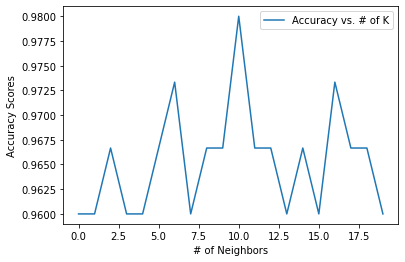

In [50]:
#setting our target array
X = iris_data.drop(columns = ["species"])
target = iris_data["species"].values

#empty list for finding optimum K value
scoreos = []

#using test_train_split and getting our test/training data
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size = .2,
                                                        random_state = 69)

#this is a loop to find our best performing k
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X=X_train, y=target_train)
    kfold = KFold(n_splits = 5, random_state = 69, shuffle = True)
    scoreos.append(cross_val_score(estimator=knn, X=X, y=target, cv=kfold))
                  
#LC to sum the arrays with their scores after the 5-Kfold cross-val
#if you uncomment the enumerate you'll see that we get the highest performing k value
#at k = 10, which has the value: .9800000000000001
total_avg = [sum(i)/5 for i in scoreos]                 
#for idx,val in enumerate(total_avg):
    #print(idx,val)
    
#plotting our accuracy vs number of neighbors
plt.plot(total_avg, label = "Accuracy vs. # of K")
plt.xlabel("# of Neighbors")
plt.ylabel("Accuracy Scores") 
plt.legend()
predicted = knn.predict(X=X_test)
expected = target_test
#confusion matrix
confusion = confusion_matrix(y_true = expected, y_pred = predicted)
confusion

#looking at it, we only see three rows, and three columns.
#this might look underwhelming but think of our data! we're trying to correctly predict
#a sub-species of IRIS plants, and there are only 3 of those sub-species
#so there is a 3x3 matrix created. 

Strategy for k with an even number of neighbors, decrease k by one until a majority decision is reached.  This HAS to happen at k=1 or before (since k=1 cannot "tie"), you might consider a recursive approach.  Lots of creative opportunities to handle this in other cases if we didn't want to decrease our k for a prediction (increase k, look at weights, etc) but we will standardize our approach.  If we were working with binary classified data (+,-), (stolen,not_stolen) etc we could merely just use k=odd to bypass this.

After your classifier is built, repeat the same steps from part 1 using your custom classifier.

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#data preparation
data = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
col_to_drop = data.columns[data.shape[1]-1]
X = data.drop(columns = [col_to_drop])
y = data[col_to_drop].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,
                                                        random_state = 69)


In [57]:
class knn_cs360(object):
    
    ## Our "Constructor" for the class
    def __init__(self,num_neighbors,distance_metric):
        self._neighbor = num_neighbors
        self._distance = distance_metric
    
    ## Giving KNN object the data
    def fit(self,x_data_inputted,y_data_inputted):
        self._x_data = np.array(x_data_inputted)
        self._y_data = np.array(y_data_inputted)
    
    ## The function that causes everything else to work, predict is going to call get_neighbors
    ## so it is able to make a prediction, which it can't do without knowing the neighbors to look at
    def predict(self,x_test):
        x_test = np.array(x_test)
        predictions = []
        if len(x_test.shape) == 1:
            return self.get_neighbors(x_test)
        for i in range(x_test.shape[0]):  
            predictions.append(self.get_neighbors(x_test[i]))
        return predictions
    
    ## We're working with arrays here that could be very massive, so we need an efficient way of 
    ## obtaining all of their distances, our class is written to handle euclidian distance which is 
    ## a straight line, and it also handles manhattan or cityblock distance (90 degree turns no straight lines)
    def distance_calculation(self,arr1,arr2):
        
        # euclidian distance calculation
        if self._distance == "euclid":
            dst = distance.euclidean(arr1,arr2)
            return dst
        ## manhattan distance calculation
        else:
            dst = distance.cityblock(arr1,arr2)
            return dst
         
    ## Let's unpack this, so get_neighbors is going to go through and find the distances from all other points
    ## in the data, and then is going to sort those distances while still keeping the classification metric
    ## (most likely a string) still tethered to those distances. After they get sorted, we need to obtain the 
    ## "K" highest scorers, and then pass those scorers to the vote function.
    def get_neighbors(self,single_pt):
        temp_neighbor = self._neighbor
        temp_y = self._y_data
        distances = []
        for i in range(len(self._x_data)):
            temp_distance = self.distance_calculation(single_pt, self._x_data[i])
            distances.append((temp_distance, temp_y[i]))
        distances.sort(key=lambda f: f[0])
        candidates = distances[:temp_neighbor] 
        return (self.vote(candidates))
    
    ## Vote will of course "vote" on the number of classifiers, so we use a dictionary to get their counts,
    ## however a dictionary isn't good for data minipulation so we will throw it straight into a list,
    ## and then sort on the counts, after we sort we need to extract our first value of the sorted
    ## list because that will be our max, then we check if that max value occurs in the list again
    ## it would obvioulsy be 2nd in line since we sorted, but ties are always possible, so in the loop
    ## at the bottom we see that if the top value is inside the list again, we recall the ENTIRE class with "K"
    ## being decremented. This step will redo the entire algorithm. Lastly once we find our highest vote, we will
    ## return that classifier, which will return to get_neighbors(), which returns to predict().
    def vote(self,candidates):
        if len(candidates) == 1:
            return (candidates[0][1])
        dc = {}
        for i in candidates:
            if i[1] in dc:
                dc[i[1]] += 1
            else:
                dc[i[1]] = 1
      
        temp = dc.items()
        dc_list = list(temp)
        dc_list.sort(key = lambda f: f[1], reverse = True)      
        top_val = dc_list[0][1]
        
        for i in dc_list[1:]:
            if i[1] == top_val:
                candidates.pop()
                return(self.vote(candidates))
        predicted_classification = dc_list[0][0]
        return (predicted_classification)

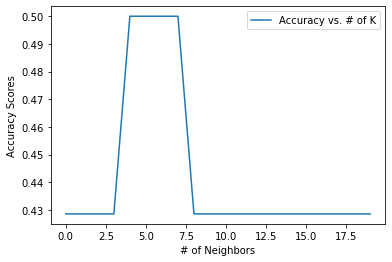

In [82]:
# Well, let's see how good our algorithm did!
# First we need to create an instance of our class and feed it the K which is the neighbors
# and whichever distance metric we decide to use in the form of a string.

#Let's find our best preforming K, unfortuatenly we can't use cross validation with the implemented algorithm
#since cross_val_score expects you to pass an SKLearn classifier which needs a scoring metric attatched to it.

f_scores = []

for i in range(1,21):
    blank_list = []
    knn = knn_cs360(i,distance_metric="euclid")
    fit = knn.fit(X_train,y_train)
    predict = knn.predict(X_train)
    expected = y_test
    
    for i,j in zip(predict,expected):
        blank_list.append(i==j)
    trues = blank_list.count(True)
    falses = blank_list.count(False)
    score_for_k = (trues/falses)
    f_scores.append(score_for_k)

plt.plot(f_scores, label = "Accuracy vs. # of K")
plt.xlabel("# of Neighbors")
plt.ylabel("Accuracy Scores")
plt.legend()


## Results

We can see that our algorithm scored the best with 3-6 neighbors with a peak of 50% accuracy.

    This would be unacceptable for a production grade Machine Learning algorithm such as all of SKLearn's classifiers. However, I was an undergraduate student when I wrote this and it was my first expierience messing with Machine Learning, let alone coding one on my own. The elephant in the room is of course my score compared to SKLearn's which is 98% peak accuracy and mine at 50% peak accuracy. I could not use SKLearn's cross validators since they are specific to their own classifiers, and having cross validation increased the non-cross validated score by about 30%. I could have also made my own cross validator to shoot for a higher score but that is a tall task in its own and is out of the scope of the original assignment. With no validation, and for a first expierience with the algorithm 50% is something to be happy about. Machine Learning algorithms aren't devised by a single entity at the end of the day.